# Conjoint Analysis: Pizza Preferences

This notebook demonstrates how to perform **Conjoint Analysis** using Python. Since there is no standard "conjoint" dataset in common libraries, we will **generate a synthetic dataset** representing a realistic scenario: **Choosing the Best Pizza**.

**Objective:** Understand how different attributes (Topping, Crust, Price) influence customer preference.

**Steps:**
1.  **Experimental Design**: Generate all possible product profiles.
2.  **Data Simulation**: Simulate customer ratings based on predefined preferences.
3.  **Preprocessing**: Convert categorical attributes into dummy variables.
4.  **Analysis**: Use Linear Regression (OLS) to estimate "Part-Worth Utilities".
5.  **Insights**: Visualize which attributes matter most.

In [6]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

sns.set(style="whitegrid")

## 1. Experimental Design

We define our product attributes and levels:
-   **Topping**: Pepperoni, Mushroom, Veggie
-   **Crust**: Thin, Thick, Stuffed
-   **Price**: $10, $12, $15

We'll create a **Full Factorial Design**, meaning we test every possible combination.

In [7]:
attributes = {
    'Topping': ['Pepperoni', 'Mushroom', 'Veggie'],
    'Crust': ['Thin', 'Thick', 'Stuffed'],
    'Price': [10, 12, 15]
}

# Generate all combinations
combinations = list(itertools.product(*attributes.values()))
df = pd.DataFrame(combinations, columns=attributes.keys())

print(f"Total Profiles: {len(df)}")
df.head()

Total Profiles: 27


,Topping,Crust,Price
0,Pepperoni,Thin,10
1,Pepperoni,Thin,12
2,Pepperoni,Thin,15
3,Pepperoni,Thick,10
4,Pepperoni,Thick,12


## 2. Data Simulation

Now, let's pretend we surveyed a customer. We'll assign a "Rating" (0-10) to each pizza profile.

To make it realistic, we'll define some **hidden preferences** (ground truth) for this simulated customer:
-   **Loves Pepperoni** (+3)
-   **Hates Veggie** (-2)
-   **Prefers Stuffed Crust** (+2)
-   **Dislikes High Price** ($15 -> -3)
-   **Likes Low Price** ($10 -> +3)

In [8]:
np.random.seed(42)

def simulate_rating(row):
    score = 5  # Base score
    
    # Topping preferences
    if row['Topping'] == 'Pepperoni': score += 3
    elif row['Topping'] == 'Mushroom': score += 1
    elif row['Topping'] == 'Veggie': score -= 2
    
    # Crust preferences
    if row['Crust'] == 'Stuffed': score += 2
    elif row['Crust'] == 'Thin': score += 1
    
    # Price preferences (Lower is better)
    if row['Price'] == 10: score += 3
    elif row['Price'] == 12: score += 0
    elif row['Price'] == 15: score -= 3
    
    # Add some random noise
    score += np.random.normal(0, 0.5)
    
    return np.clip(score, 0, 10)

df['Rating'] = df.apply(simulate_rating, axis=1)
df.head()

,Topping,Crust,Price,Rating
0,Pepperoni,Thin,10,10.000000
1,Pepperoni,Thin,12,8.930868
2,Pepperoni,Thin,15,6.323844
3,Pepperoni,Thick,10,10.000000
4,Pepperoni,Thick,12,7.882923


## 3. Preprocessing

Conjoint analysis typically uses **Dummy Coding** (One-Hot Encoding) for categorical variables. 
For `Price`, even though it's numeric, we often treat it as categorical in conjoint to capture non-linear preferences (e.g., the drop from 10 to 12 might hurt less than 12 to 15).

In [9]:
# Convert Price to string so it gets dummy encoded
df['Price_Cat'] = df['Price'].astype(str)

# Create dummy variables
df_encoded = pd.get_dummies(df, columns=['Topping', 'Crust', 'Price_Cat'], drop_first=True)

print("Encoded columns:", df_encoded.columns.tolist())
df_encoded.head()

Encoded columns: ['Price', 'Rating', 'Topping_Pepperoni', 'Topping_Veggie', 'Crust_Thick', 'Crust_Thin', 'Price_Cat_12', 'Price_Cat_15']


,Price,Rating,Topping_Pepperoni,Topping_Veggie,Crust_Thick,Crust_Thin,Price_Cat_12,Price_Cat_15
0,10,10.000000,True,False,False,True,False,False
1,12,8.930868,True,False,False,True,True,False
2,15,6.323844,True,False,False,True,False,True
3,10,10.000000,True,False,True,False,False,False
4,12,7.882923,True,False,True,False,True,False


## 4. Model Training (OLS Regression)

We use **Ordinary Least Squares (OLS)** regression. 
-   **Target (Y)**: Rating
-   **Features (X)**: The dummy variables for our attributes.

The **coefficients** of this model represent the **Part-Worth Utilities** (relative to the reference category that was dropped).

In [10]:
Y = df_encoded['Rating']
X = df_encoded.drop(['Rating', 'Price'], axis=1) # Drop original Price column too
X = X.astype(float) # Cast to float to avoid ValueError with boolean/object types
X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     78.41
Date:                Thu, 27 Nov 2025   Prob (F-statistic):           7.78e-13
Time:                        13:52:11   Log-Likelihood:                -24.487
No. Observations:                  27   AIC:                             62.97
Df Residuals:                      20   BIC:                             72.05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 9.9715      0.35

## 5. Analysis & Visualization

Let's extract the coefficients (Part-Worths) and visualize them. 
*Note: The 'reference' categories (the ones dropped by `drop_first=True`) effectively have a utility of 0 relative to the constant.*

C:\Users\amana\AppData\Local\Temp\ipykernel_25060\572301997.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=part_worths.values, y=part_worths.index, palette='viridis')


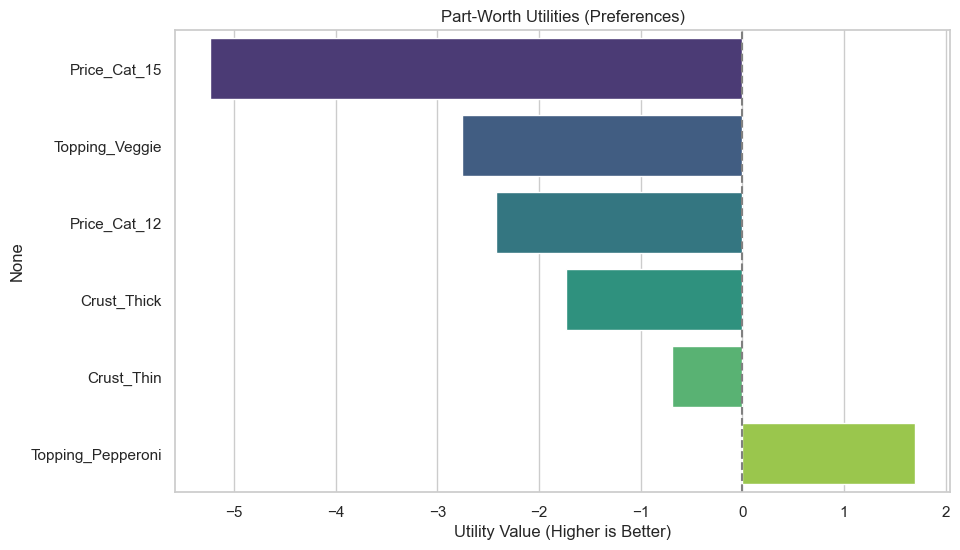

In [11]:
# Extract Part-Worths
part_worths = model.params.drop('const')
part_worths = part_worths.sort_values()

plt.figure(figsize=(10, 6))
sns.barplot(x=part_worths.values, y=part_worths.index, palette='viridis')
plt.title('Part-Worth Utilities (Preferences)')
plt.xlabel('Utility Value (Higher is Better)')
plt.axvline(0, color='grey', linestyle='--')
plt.show()

### Interpretation
-   **Positive bars**: Features the customer likes more than the baseline.
-   **Negative bars**: Features the customer dislikes compared to the baseline.
-   **Magnitude**: The longer the bar, the stronger the preference.

In our simulation, we expect **Pepperoni**, **Stuffed Crust**, and **Price_Cat_10** (if it was the baseline, others would be negative) to show high utility.